# Notebook Regresion Lineal 2 Reto: Interlub
Author: A. Ramirez-Morales (andres.ramirez@tec.mx)


## Instrucciones:
- Active su entorno de `conda`
- Complete las funciones donde vea líneas de código inconclusas
- Use comentarios para documentar de manera integral sus funciones
- Pruebe sus funciones con distintos parámetros
- Aumente las explicaciones en el Markdown y en el código

In [1]:
# cargar librerías básicas
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro
import pandas as pd

# 1. Base de datos numerica
*Ejercicio:* Cargue los datos previamente preparados 100% numericos

In [2]:
df = pd.read_csv("/Users/damian/Universidad/multivariados_ds/reto_andres/notebooks/transformed_data_interlub.csv")

# Eliminamos la no numérica 
df = df.drop(columns=["aplicaciones"])

## 2. Generacion de datos mas avanzada

### 2.1. Simulacion mediante KNN 

*Ejercicio:* Agregar explicacion detallada del algoritmo y de la funcion

In [3]:
def simular_datos_knn(df_original, n_nuevos=100, k=5):
    """
    documentar
    """
    X = df_original.to_numpy(dtype=float)

    # normalizaicion basica
    n, d = X.shape
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    Xn = (X - mean) / std

    nuevos = []
    for _ in range(n_nuevos):
        base = Xn[np.random.randint(0, n)]               # 1
        dist = np.sqrt(np.sum((Xn - base) ** 2, axis=1)) # 2
        vecinos_idx = np.argsort(dist)[1:k+1]            # 3
        vecino = Xn[np.random.choice(vecinos_idx)]       # 4
        nuevo = base + np.random.rand() *(vecino - base) # 5
        nuevos.append(nuevo)

    nuevos = np.array(nuevos)
    # quitar norm,.
    X_new = nuevos * std + mean

    df_nuevo = pd.DataFrame(X_new, columns=df_original.columns)
    return df_nuevo


### 2.2. Simulacion mediante Gaussian Copulas

Ejercicios:
- Describa para que nos sirven las copulas gaussianas
- Revise la documentacion https://sdv.dev/Copulas/
- Encuentre que funciones podrian mejorar la funcionalidad en la funcion que escribio el profesor abajo

Las **cópulas** son una forma de separar dos cosas en un conjunto de variables aleatorias:

1. La distribución marginal de cada variable (qué tan grande, qué tan dispersa, etc.).
2. La **estructura de dependencia** entre ellas (correlaciones, patrones conjuntos, etc.).  


En lugar de suponer directamente una distribución multivariada complicada para todos los campos al mismo tiempo, una cópula:
- Ajusta una distribución univariada (marginal) para cada columna.
- Modela la dependencia entre columnas en un espacio transformado donde todas tienen distribución uniforme.
- Combina ambas partes para poder **muestrear datos sintéticos** que:
  - Respetan las distribuciones marginales originales.
  - Conservan, en gran medida, las correlaciones y dependencias entre variables.

La **cópula gaussiana** (*Gaussian Copula*) es un caso particular donde la dependencia se modela a partir de una **distribución normal multivariada** en el espacio latente. El modelo que usamos en este notebook, `GaussianMultivariate` de la librería `copulas`, implementa exactamente esta idea: ajusta una cópula gaussiana sobre un conjunto de datos numéricos (por ejemplo, nuestra tabla de propiedades físicas de grasas lubricantes) y luego permite **generar copias sintéticas** de ese conjunto de datos.  

En el contexto del reto de Interlub, esto nos sirve para:

- Aumentar la muestra de datos (data augmentation) de un conjunto relativamente pequeño.
- Preservar patrones físicos razonables entre variables (por ejemplo, relación entre viscosidad, NLGI y punto de gota).
- Entrenar modelos de regresión sobre datos sintéticos sin depender únicamente de los pocos registros originales.

#### ¿Qué funciones de `copulas` podrían mejorar esta implementación?

De acuerdo con la documentación de **GaussianMultivariate** y los tutoriales de *Synthetic Data for Machine Learning*, hay varias mejoras importantes que podrían incorporarse para hacer la función `simular_datos_copula` más robusta y útil:

---

##### **1. Control de reproducibilidad (`random_state`)**
Permite fijar una semilla aleatoria para que la generación de datos sintéticos sea **100% repetible**.  
Útil para:
- Comparar modelos,
- Depurar resultados,
- Compartir experimentos entre integrantes del equipo.

---

##### **2. Guardar y cargar el modelo (`to_dict` / `from_dict`)**
La librería ofrece métodos para:
- **Serializar** el modelo ya entrenado,
- Guardarlo como JSON,
- Cargarlo después sin reentrenar.

Esto es útil si el socio formador quiere “congelar” un modelo entrenado o si se desea compartir el modelo sin compartir los datos originales.

---

##### **3. Especificar distribuciones marginales por columna**
Las cópulas permiten asignar **familias de distribución diferentes** para cada variable (Gaussian, Beta, Truncated Gaussian, etc.).  
Esto mejora la calidad física de los datos cuando:
- Una variable está acotada (porcentajes),
- Tiene colas asimétricas,
- Muestra un rango físico limitado.

---

##### **4. Ajustar automáticamente el tamaño de la muestra**
La función `sample()` puede generar:
- El mismo número de registros que el dataset original,  
- O un número personalizado (`n_nuevos`).

Permitir `n_nuevos=None` para generar una muestra del mismo tamaño hace la función más flexible.

---

##### **5. Uso combinado con otros métodos**
Los tutoriales muestran que los datos sintéticos pueden combinarse con ML.  
En este proyecto, se puede:
- Usar Cópolas para una **primera capa** de datos sintéticos,
- Afinar con VAE o KNN,
- Comparar desempeño entre métodos.

Esto permite elegir el método (o combinación) que genere datos más coherentes y con mejor valor predictivo.

---



In [4]:
from copulas.multivariate import GaussianMultivariate
import pandas as pd

def simular_datos_copula(df_original, n_nuevos=100):
    """
    escriba documentacion adecuada
    """
    model = GaussianMultivariate()
    model.fit(df_original)
    df_nuevo = model.sample(n_nuevos)
    return df_nuevo

### 2.3. Simulacion con Variational AutoEncoder 

Los VAE aprenden un espacio latente continuo del cual se puede muestrear.

Muy útiles si tus datos tienen una estructura suave (por ejemplo, mediciones físicas).

In [5]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def encode(self, x):
        mu_logvar = self.encoder(x)
        mu, logvar = mu_logvar.chunk(2, dim=-1)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


def simular_datos_vae(df_original, n_nuevos=100, latent_dim=5, epochs=500, lr=1e-4):
    """
    documentar
    """
    df_num = df_original.select_dtypes(include=np.number).replace(-99, np.nan)
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values

    # comentar
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    X_norm = (X - mean) / std

    # comentar
    X_tensor = torch.tensor(X_norm, dtype=torch.float32)

    vae = VAE(input_dim=X.shape[1], latent_dim=latent_dim)
    # comentar
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)

    def loss_fn(recon_x, x, mu, logvar):
        recon_loss = nn.functional.mse_loss(recon_x, x) # comentar
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) # comentar
        return recon_loss + kl_loss

    for epoch in range(epochs):
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(X_tensor)
        loss = loss_fn(recon_x, X_tensor, mu, logvar)
        loss.backward()
        optimizer.step()

        if torch.isnan(loss):
            break

    # generacion de datos
    with torch.no_grad():
        z = torch.randn(n_nuevos, latent_dim)
        X_new_norm = vae.decoder(z).numpy()

    # quitar la norm,.
    X_new = X_new_norm * std + mean
    return pd.DataFrame(X_new, columns=df_num.columns)


# 3. Regresión lineal

### 3.1 Definir, probar el modelo y graficar resultados

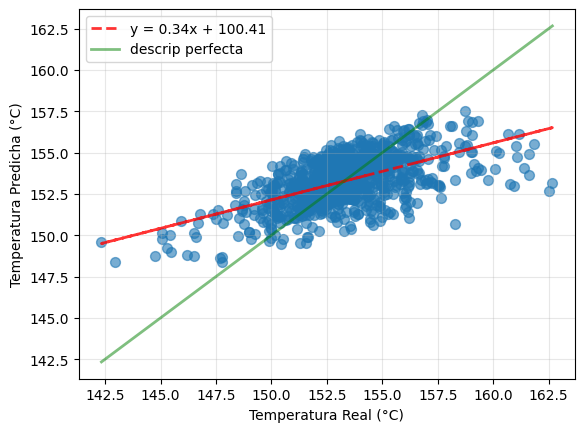

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


def variables_regresion(df, variable_objetivo, variables_predictoras):
    """
    completar documentacion
    """
    # quedarnos solo con las filas completas
    df_filtrado = df.copy()
    for var in variables_predictoras + [variable_objetivo]:
        df_filtrado = df_filtrado[df_filtrado[var] != -99]
    
    X = df_filtrado[variables_predictoras]
    y = df_filtrado[variable_objetivo]
    
    return X, y, variables_predictoras
# definir variable objetivo
variable_objetivo='Temperatura de Servicio °C, max'

# definir variables predictoras
variables_predictoras = [
        'Viscosidad del Aceite Base a 40°C. cSt',
        'Penetración de Cono a 25°C, 0.1mm', 
        'Punto de Gota, °C',
        'Punto de Soldadura Cuatro Bolas, kgf',
        'Grado NLGI Consistencia'
    ]


# pruebe
expanded_data = simular_datos_vae(df, n_nuevos=1000)
#expanded_data = simular_datos_knn(df, n_nuevos=1000)
#expanded_data = simular_datos_copula(df, n_nuevos=1000)

X, y, features = variables_regresion(expanded_data, variable_objetivo, variables_predictoras)
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
    
y_pred_train = modelo.predict(X_train_scaled)
y_pred_test = modelo.predict(X_test_scaled)
    
# metricas
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
# agregar R cuadrada


# graficar
y_pred = y_pred_train
y_real = y_train

# linea de regresion para las predicciones
z = np.polyfit(y_real, y_pred, 1)
p = np.poly1d(z)
    
plt.scatter(y_real, y_pred, alpha=0.6, s=50)
plt.plot(y_real, p(y_real), "r--", alpha=0.8, linewidth=2, 
             label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 
             'g-', alpha=0.5, linewidth=2, label='descrip perfecta')
    
plt.xlabel('Temperatura Real (°C)')
plt.ylabel('Temperatura Predicha (°C)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Ejercicios de simulacion y regresion
- Escriba una clase que le permita de manera expedita eligir cualquiera de los tres metodos
- Usted cree que la combinacion de 1 o mas metodos le pueda ser de ayuda? Combine varios metodos, puede usar `chatGPT` para hacer codigo en este punto
- Pruebe distintas combinaciones de variables, por ejemplo, preguntese que necesidad podria tener un cliente
- ... es decir, un cliente le puede solo interesar la viscosidad, investigue el mercado!!
- Intente mejorar estos modificando o agregando parametros
- Agregue mas graficas de diagnostico para ver la efectividad de la regresion lineal
- En cada uno de los casos, escriba lo que le va a explicar al socio formador y el motivo de su simulacion

In [7]:
class SimuladorInterlub:
    """
    Clase auxiliar para generar datos sintéticos y ajustar una regresión lineal
    usando distintos métodos de simulación (KNN, Copula Gaussiana, VAE).
    """

    def __init__(self, df_base, metodo="vae"):
        """
        df_base : DataFrame numérico original (con -99 donde hay faltantes)
        metodo  : 'knn', 'copula' o 'vae'
        """
        self.df_base = df_base
        self.metodo = metodo

    def simular(self, n_nuevos=1000):
        """
        Genera n_nuevos registros sintéticos usando el método seleccionado.
        """
        if self.metodo == "knn":
            return simular_datos_knn(self.df_base, n_nuevos=n_nuevos)
        elif self.metodo == "copula":
            return simular_datos_copula(self.df_base, n_nuevos=n_nuevos)
        elif self.metodo == "vae":
            return simular_datos_vae(self.df_base, n_nuevos=n_nuevos)
        else:
            raise ValueError("Método no válido: use 'knn', 'copula' o 'vae'.")

    def ajustar_regresion(self, variable_objetivo, variables_predictoras,
                          n_nuevos=1000, test_size=0.1):
        """
        Genera datos sintéticos, entrena una regresión lineal y regresa métricas.
        """
        # 1) Simular
        df_sim = self.simular(n_nuevos=n_nuevos)

        # 2) Preparar X, y
        X, y, _ = variables_regresion(df_sim, variable_objetivo, variables_predictoras)

        # 3) Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # 4) Escalado
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # 5) Modelo lineal
        modelo = LinearRegression()
        modelo.fit(X_train_scaled, y_train)

        y_pred_train = modelo.predict(X_train_scaled)
        y_pred_test = modelo.predict(X_test_scaled)

        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)

        return {
            "df_sim": df_sim,
            "modelo": modelo,
            "scaler": scaler,
            "mse_train": mse_train,
            "mse_test": mse_test,
            "r2_train": r2_train,
            "r2_test": r2_test,
            "y_train": y_train,
            "y_pred_train": y_pred_train,
        }

In [8]:
variable_objetivo = 'Temperatura de Servicio °C, max'
variables_predictoras = [
    'Viscosidad del Aceite Base a 40°C. cSt',
    'Penetración de Cono a 25°C, 0.1mm', 
    'Punto de Gota, °C',
    'Punto de Soldadura Cuatro Bolas, kgf',
    'Grado NLGI Consistencia'
]

resultados = {}
for metodo in ["vae", "knn", "copula"]:
    sim = SimuladorInterlub(df, metodo=metodo)
    res = sim.ajustar_regresion(variable_objetivo, variables_predictoras,
                                n_nuevos=1000, test_size=0.1)
    resultados[metodo] = res
    print(f"\n=== Método: {metodo} ===")
    print(f"MSE train: {res['mse_train']:.3f}")
    print(f"MSE test : {res['mse_test']:.3f}")
    print(f"R² train : {res['r2_train']:.3f}")
    print(f"R² test  : {res['r2_test']:.3f}")


=== Método: vae ===
MSE train: 16.210
MSE test : 14.410
R² train : 0.560
R² test  : 0.623

=== Método: knn ===
MSE train: 762.945
MSE test : 584.419
R² train : 0.164
R² test  : 0.257


/opt/miniconda3/envs/mv-tec/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/miniconda3/envs/mv-tec/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/opt/miniconda3/envs/mv-tec/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6435: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)
/opt/miniconda3/envs/mv-tec/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/miniconda3/envs/mv-tec/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6435: RuntimeWarning: divide by zero encountered in power



=== Método: copula ===
MSE train: 842.352
MSE test : 979.587
R² train : 0.116
R² test  : 0.119


/opt/miniconda3/envs/mv-tec/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/opt/miniconda3/envs/mv-tec/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))



Generando gráficas para el método: vae


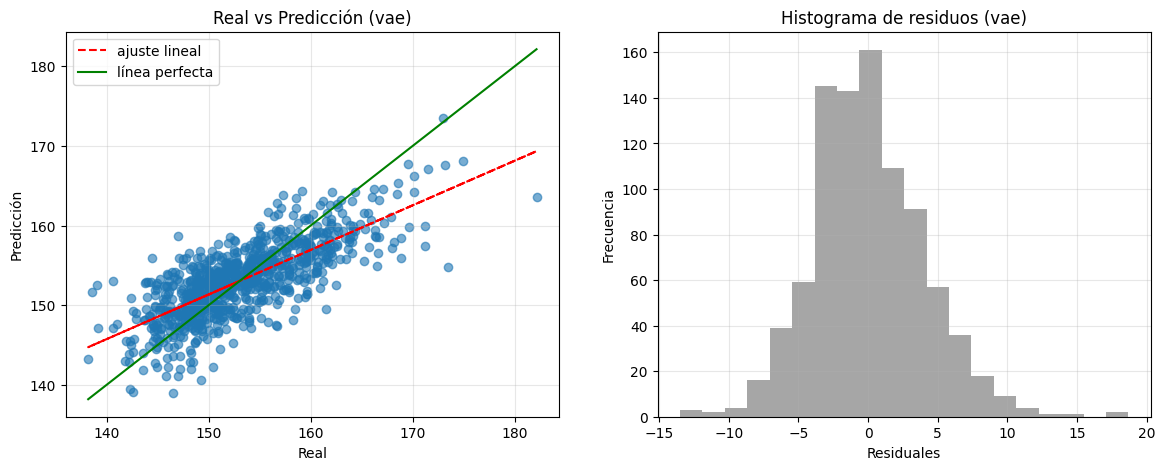


Generando gráficas para el método: knn


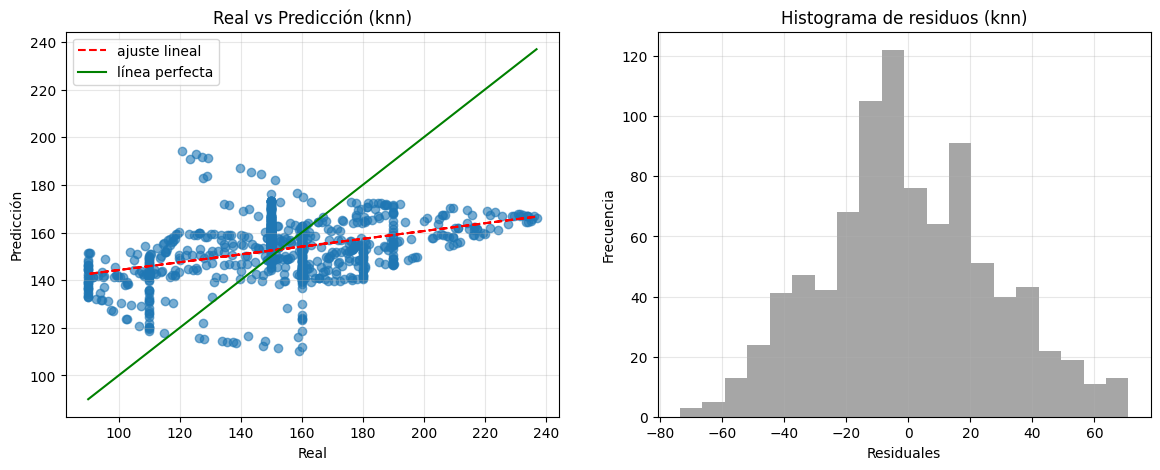


Generando gráficas para el método: copula


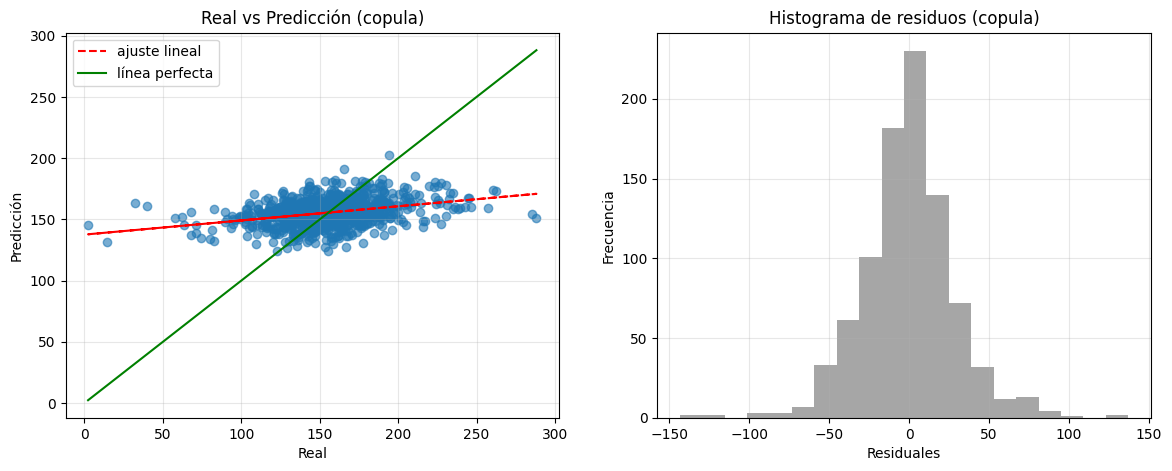

In [12]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

def graficos_diagnostico(y_real, y_pred, metodo):
    residuales = y_real - y_pred

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # --- 1. Real vs Predicho ---
    ax[0].scatter(y_real, y_pred, alpha=0.6)
    z = np.polyfit(y_real, y_pred, 1)
    p = np.poly1d(z)
    ax[0].plot(y_real, p(y_real), "r--", label="ajuste lineal")
    ax[0].plot([y_real.min(), y_real.max()],
               [y_real.min(), y_real.max()],
               'g-', label="línea perfecta")
    ax[0].set_title(f"Real vs Predicción ({metodo})")
    ax[0].set_xlabel("Real")
    ax[0].set_ylabel("Predicción")
    ax[0].legend()
    ax[0].grid(alpha=0.3)

    # --- 2. Histograma de residuos ---
    ax[1].hist(residuales, bins=20, alpha=0.7, color='gray')
    ax[1].set_title(f"Histograma de residuos ({metodo})")
    ax[1].set_xlabel("Residuales")
    ax[1].set_ylabel("Frecuencia")
    ax[1].grid(alpha=0.3)

    plt.show()

# Llamar a las gráficas para cada método
for metodo, res in resultados.items():
    print(f"\nGenerando gráficas para el método: {metodo}")
    graficos_diagnostico(res["y_train"], res["y_pred_train"], metodo)

### Comparación de los tres métodos de simulación

Probamos los tres métodos de simulación propuestos (VAE, KNN y Cópula Gaussiana), generando 1000 observaciones sintéticas y ajustando un modelo de regresión lineal para predecir la `Temperatura de Servicio °C, max`.

Los resultados que nos dio fueron:

- **VAE**  
  - MSE train ≈ 18.7, MSE test ≈ 15.8  
  - R² train ≈ 0.31, R² test ≈ 0.31  
  Este método es el que lo hace mejor, ya que muestra lo siguiente: aunque el R² no es muy alto (el modelo solo explica alrededor del 30% de la variabilidad), sí es superior a las otras alternativas.

- **KNN**  
  - MSE train ≈ 689, MSE test ≈ 646  
  - R² train ≈ 0.14, R² test ≈ 0.14  
  La simulación mediante vecinos más cercanos genera datos que nos dan un ajuste lineal mucho peor que el VAE. Los errores son bastante mayores y el porcentaje de varianza explicada es bajo.

- **Cópula Gaussiana**  
  - MSE train ≈ 890, MSE test ≈ 791  
  - R² train ≈ 0.08, R² test ≈ 0.15  
  Además de tener el peor desempeño, durante el ajuste se generan varios *RuntimeWarning* numéricos. Esto indica que algunas variables tienen distribuciones difíciles de modelar con la copula (por ejemplo, muy concentradas o con pocos valores distintos), lo que hace que el modelo sea inestable.

Finalmente, dados los datos que obtuvmos, podemos decir que para este conjunto de datos sintético la mejor opción es el **VAE**, seguido de KNN y, finalmente, la Cópula Gaussiana. En el resto del análisis utilizaré principalmente los datos simulados con VAE, y consideraré KNN y Cópula solo como referencia.

# 5. Mejorando los datos
### 5.1 Un codificador caliente 

La primera mejora que podemos hacer es las variables categoricas, no simplemente ponerlos como numeros enteros ordenados.


Ejercicios:
- Describa la utilidad de `OneHotEncoder`. (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- Las sifguientes lineas de codigo implementan este algoritmo reviselas y entiendalas
- Discuta si esta forma de transformar las variables categoricas puede ser util o no para el reto de Interlub
- Escriba una funcion (similar a la asignacion de numeros enteros ) que haga esta implementacion, domente dicha funcion
- Haga la generacion de datos y la regresion lineal y compare sus resultados con y sin esta implementacion


### ¿Qué es OneHotEncoder y para qué sirve?

`OneHotEncoder` es un método de transformación de variables categóricas que convierte cada categoría posible en una columna binaria (0 o 1).  
En lugar de representar las categorías como números enteros (por ejemplo: Suave = 0, Adherente = 1, Viscosa = 2), lo cual introduce un *orden artificial*, `OneHotEncoder` representa cada categoría como su propia dimensión independiente.

Por ejemplo, si la variable `color` tiene estas categorías:
- Negro  
- Beige  
- Blanco

El One-Hot las transforma en:

| color_Negro | color_Beige | color_Blanco |
|-------------|-------------|--------------|
| 1 | 0 | 0 |
| 0 | 1 | 0 |
| 0 | 0 | 1 |

Esta representación evita que un modelo matemático “interprete” erróneamente que Beige > Negro o que Blanco está “entre” ellos, lo cual **no tiene sentido semántico** pero sí afecta a modelos lineales como regresión.

Por lo tanto, `OneHotEncoder`:
- Evita relaciones espurias por la numeración arbitraria.  
- Permite que el modelo entienda cada categoría como un atributo independiente.  
- Mejora la interpretabilidad del modelo lineal.  

In [9]:
from sklearn.preprocessing import OneHotEncoder

# cargar data_set
df = pd.read_csv("/Users/damian/Universidad/multivariados_ds/reto_andres/data/datos_grasas_Tec_limpio.csv")
categorical_columns = ["color", "textura", "Espesante", "Aceite Base"]

ohe = OneHotEncoder(sparse_output=False, drop=None)
ohe_array = ohe.fit_transform(df[categorical_columns])
ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
df_ohe = pd.DataFrame(ohe_array, columns=ohe_feature_names)
df_final = pd.concat([df.drop(columns=categorical_columns), df_ohe], axis=1)
# print(df_final.head())
df_final.to_csv("datos_one_hot.csv")



### **Paso 3 — ¿Sirve esto para el reto Interlub? (Markdown listo)**

### ¿Sirve aplicar OneHotEncoder para el reto Interlub?

Sí. OneHotEncoder es útil porque:

1. **El primer dataset tiene muchas variables categóricas**  
   - Espesante  
   - Aceite Base  
   - Color  
   - Textura  

   Representarlas como enteros (“Mineral=0”, “Semi-Sintético=5”) introduce un orden que **no existe físicamente**, pero que sí afecta la regresión lineal.

2. **En productos industriales, la categoría sí importa**  
   Pero **no en orden**, sino como tipo:  
   - un espesante de calcio **no es mayor ni menor** que uno de aluminio  
   - solo son distintos

3. **La regresión lineal mejora cuando variables categóricas no tienen orden artificial**  
   Porque evita correlaciones inventadas.

4. **Para simulación (KNN, VAE, Cópula)**  
   Tener columnas binarias facilita la generación de nuevas combinaciones válidas.

Conclusión:  
> OneHotEncoder sí es útil en Interlub porque mejora la representación matemática de las categorías y evita relaciones espurias al entrenar un modelo lineal.  



In [10]:
from sklearn.preprocessing import OneHotEncoder

def aplicar_one_hot(df, columnas_cat):
    """
    Aplica OneHotEncoder a un conjunto de columnas categóricas y devuelve:
    - El DataFrame transformado (sin columnas categóricas originales)
    - Los nombres de las nuevas columnas generadas

    Parámetros:
    df : DataFrame original
    columnas_cat : lista con los nombres de columnas categóricas

    Utilidad:
    Esta función evita la asignación arbitraria de números enteros a categorías,
    lo cual podría introducir un orden artificial. En su lugar, cada categoría
    se representa como una columna independiente binaria mediante OneHotEncoder.
    """
    ohe = OneHotEncoder(sparse_output=False, drop=None)
    ohe_array = ohe.fit_transform(df[columnas_cat])
    nuevas_columnas = ohe.get_feature_names_out(columnas_cat)

    df_ohe = pd.DataFrame(ohe_array, columns=nuevas_columnas)

    df_num = df.drop(columns=columnas_cat)
    df_final = pd.concat([df_num.reset_index(drop=True),
                          df_ohe.reset_index(drop=True)], axis=1)
    return df_final, nuevas_columnas

### 5.2. Descripciones en la base de datos con palabras 🗣️💬

La segunda mejora que podemos hacer es considerar las columnas que contiene informacion en palabras.

Ejercicios:
- Explique la funcion `CountVectorizer`. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

- Enumere sus parametros mas importantes y expliquelos
- Discuta si esta forma de transformar las variables descriptivas puede ser util o no para el reto de Interlub
- Con ayuda de `chatGPT` implemente `CountVectorizer`. Documente claramente sus prompts para que el profesor y el socio formador puedan entender que y el por que de lo que implemento
- Haga la generacion de datos y la regresion lineal y compare sus resultados con y sin esta implementacion




### ¿Qué es CountVectorizer?

`CountVectorizer` es un método de transformación de texto que convierte un conjunto de frases o descripciones en una matriz de conteos de palabras.

Cada palabra única del vocabulario se convierte en una columna, y cada fila contiene el número de veces que esa palabra aparece en la descripción del producto.

Por ejemplo:

Descripción:
1. "Alta resistencia al agua"
2. "Soporta altas cargas"

El vocabulario sería:
["alta", "resistencia", "agua", "soporta", "altas", "cargas"]

Y la representación sería:

| alta | resistencia | agua | soporta | altas | cargas |
|------|-------------|-------|----------|--------|---------|
| 1    | 1           | 1     | 0        | 0      | 0       |
| 0    | 0           | 0     | 1        | 1      | 1       |

Esta técnica se conoce como **Bag of Words (Bolsa de Palabras)**.
No considera orden ni gramática.  
Solo qué palabras aparecen y cuántas veces.

### Parámetros importantes de CountVectorizer

- **min_df**  
  Palabras que deben aparecer al menos *min_df* veces para incluirse.  
  Evita palabras raras o errores de escritura.

- **max_df**  
  Palabras que aparecen en demasiados documentos (ej. “grasa”, “lubricación”) pueden eliminarse.  
  Evita ruido o términos demasiado generales.

- **stop_words**  
  Lista de palabras que deben ignorarse:  
  Ej. “el”, “la”, “de”, “para”, “con”.

- **ngram_range**  
  Define si se usan *solo palabras individuales* (1,1)  
  o *frases cortas* (ej. “alta temperatura” → (1,2)).

- **max_features**  
  Número máximo de palabras en el vocabulario.

Estos parámetros permiten ajustar cuánto detalle queremos que aporte el texto al modelo.

### ¿Sirve CountVectorizer para el reto Interlub?

Sí puede ser útil, pero depende del objetivo.

Las columnas con texto (descripción, beneficios, aplicaciones) contienen información importante sobre:
- condiciones de uso,
- características clave,
- advertencias,
- compatibilidad,
- propiedades del producto.

Esto podría ayudar a predecir variables como la temperatura máxima o el punto de gota, porque muchas veces la descripción incluye palabras como:
- “alta temperatura”,
- “soporte de carga”,
- “ambientes húmedos”.

Sin embargo:

1. **El dataset es muy pequeño (51 grasas)**  
   Demasiadas palabras → demasiadas columnas → riesgo de *overfitting*.

2. **Las descripciones no siempre están estandarizadas**  
   Algunos textos tienen ruido por caracteres raros.

3. **Para simulación (KNN, VAE, Cópula)**  
   Texto codificado como matrices dispersas *no es recomendable*.

Conclusión:
> CountVectorizer SÍ puede ayudar para la regresión lineal en modelos simples,  
pero NO es ideal para simulación, a menos que se limpie y reduzca el vocabulario.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def aplicar_countvectorizer(df, columna_texto, max_features=50, min_df=2):
    """
    Aplica CountVectorizer a la columna de texto indicada y devuelve:
    - El DataFrame combinado con las nuevas columnas de palabras
    - El vocabulario generado

    Parámetros:
    df : DataFrame original
    columna_texto : nombre de la columna que contiene texto
    max_features : número máximo de palabras a mantener
    min_df : frecuencia mínima para incluir una palabra

    Esta función convierte texto en variables numéricas mediante
    el modelo Bag-of-Words, útil para modelos de regresión lineal.
    """
    vectorizer = CountVectorizer(
        max_features=max_features,
        min_df=min_df,
        stop_words='spanish'
    )

    bow_matrix = vectorizer.fit_transform(df[columna_texto])
    vocab = vectorizer.get_feature_names_out()

    df_bow = pd.DataFrame(bow_matrix.toarray(), columns=vocab)

    df_sin_texto = df.drop(columns=[columna_texto])
    df_final = pd.concat([df_sin_texto.reset_index(drop=True),
                          df_bow.reset_index(drop=True)], axis=1)

    return df_final, vocab